In [1]:
import numpy as np
import torch
from torch import nn
from torch.distributions import MultivariateNormal as MNormal
from torch.distributions import Normal, Cauchy, Categorical
import pyro
from pyro.infer import MCMC, HMC as pyro_hmc, NUTS as pyro_nuts
from matplotlib import pyplot as plt
import seaborn as sns
from typing import Optional, List, Tuple, Iterable, Callable, Union
from tqdm import tqdm, trange
from scipy.stats import gaussian_kde

sns.set_theme('talk', style="white")


In [2]:
N_CHAINS = 10
N_SAMPLES = 1000
BURN_IN = 100

PROJ_DIM1 = 0
PROJ_DIM2 = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# some code for drawing

def ema(series: Iterable, n: int) -> List:
    """
    returns an n period exponential moving average for
    the time series
    """
    series = np.array(series)
    ema = []
    j = 1

    #get n sma first and calculate the next n period ema
    sma = sum(series[:n]) / n
    multiplier = 2 / float(1 + n)
    ema.append(sma)

    #EMA(current) = ( (Price(current) - EMA(prev) ) x Multiplier) + EMA(prev)
    ema.append(( (series[n] - sma) * multiplier) + sma)

    #now calculate the rest of the values
    for i in series[n+1:]:
        tmp = ( (i - ema[j]) * multiplier) + ema[j]
        j = j + 1
        ema.append(tmp)

    return ema

def plot_dens_proj(ax, target, batch_size, xlim=None, ylim=None):
    N_pts = 100

    if xlim is None or ylim is None:
        a = 2.0
        xlim = ylim = (-2*a, 2*a)
    xlist = np.linspace(*xlim, N_pts)
    ylist = np.linspace(*ylim, N_pts)
    X, Y = np.meshgrid(xlist, ylist)
    points = np.zeros((X.shape[0],X.shape[1], 2),dtype=float)
    points[..., PROJ_DIM1] = X
    points[..., PROJ_DIM2] = Y
    points = points.reshape(-1, 2)

    dens_vals = torch.cat([target.log_prob(batch.to(device)).detach().cpu() \
        for batch in torch.FloatTensor(points).split(batch_size)], 0)
    dens_vals -= torch.logsumexp(dens_vals, 0)
    dens_vals = (dens_vals).exp().reshape(N_pts, N_pts).numpy()

    cp = ax.contour(X, Y, dens_vals, levels=10, cmap='inferno')
    ax.set_title(r'$\bar{p}_t(z) $')
    ax.set_xlabel(fr'z{PROJ_DIM1 + 1}')
    ax.set_ylabel(fr'z{PROJ_DIM2 + 1}')
    ax.set_aspect('equal')

    return cp

def plot_log_dens_proj(ax, target, batch_size, xlim=None, ylim=None):
    N_pts = 100

    if xlim is None or ylim is None:
        a = 2.0
        xlim = ylim = (-2*a, 2*a)
    xlist = np.linspace(*xlim, N_pts)
    ylist = np.linspace(*ylim, N_pts)
    X, Y = np.meshgrid(xlist, ylist)
    points = np.zeros((X.shape[0],X.shape[1], 2),dtype=float)
    points[..., PROJ_DIM1] = X
    points[..., PROJ_DIM2] = Y
    points = points.reshape(-1, 2)

    log_dens_vals = torch.cat([target.log_prob(batch.to(device)).detach().cpu() \
        for batch in torch.FloatTensor(points).split(batch_size)], 0)
    log_dens_vals = log_dens_vals.reshape(N_pts, N_pts).numpy()

    cp = ax.contourf(X, Y, log_dens_vals, levels=10, cmap='inferno')
    ax.set_title(r'$\log \bar{p}_t(z) $')
    ax.set_xlabel(fr'z{PROJ_DIM1 + 1}')
    ax.set_ylabel(fr'z{PROJ_DIM2 + 1}')
    ax.set_aspect('equal')

    return cp

In [4]:
def NUTS(start,
        target, 
        n_samples: int,
        burn_in: int, 
        *, 
        step_size: float,
        verbose: bool = False) -> torch.FloatTensor:
    """
    No-U-Turn Sampler

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """

    x = start.clone()
    x.requires_grad_(False)
    def energy(z):
        z = z["points"]
        return -target.log_prob(z).sum()

    kernel = pyro_nuts(
        potential_fn=energy, step_size=step_size, full_mass=False
        )

    init_params = {"points": x}
    mcmc_true = MCMC(
        kernel=kernel,
        num_samples=n_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = q_true.view(-1, *start.shape).detach().cpu()

    return samples_true


def HMC(start,
        target, 
        n_samples: int,
        burn_in: int, 
        *, 
        step_size: float,
        num_leapfrog_steps: float = 1,
        verbose: bool = False) -> torch.FloatTensor:
    """
    Hamiltonian Monte Carlo

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """

    x = start.clone()
    x.requires_grad_(False)
    def energy(z):
        z = z["points"]
        return -target.log_prob(z).sum()

    kernel = pyro_hmc(
        potential_fn=energy, step_size=step_size, num_steps=num_leapfrog_steps, full_mass=False
        )

    init_params = {"points": x}
    mcmc_true = MCMC(
        kernel=kernel,
        num_samples=n_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = q_true.view(-1, *start.shape).detach().cpu()

    return samples_true

In [5]:
# def ULA(start: torch.FloatTensor, 
#         target, 
#         n_samples: int,
#         burn_in: int,
#         *, 
#         step_size: float, 
#         verbose: bool=False) -> torch.FloatTensor:
#     """
#     Unadjusted Langevin Algorithm

#     Args:
#         start - strating points of shape [n_chains, dim]
#         target - target distribution instance with method "log_prob"
#         n_samples - number of last samples from each chain to return
#         burn_in - number of first samples from each chain to throw away
#         step_size - step size for drift term
#         verbose - whether to show iterations' bar

#     Returns:
#         tensor of chains with shape [n_samples, n_chains, dim]
#     """
#     chains = []
#     x = start.clone()
#     x.requires_grad_(True)
#     x.grad = None
    
#     range_ = trange if verbose else range
#     for step_id in range_(n_samples + burn_in):
#         log_prob = target.log_prob(x)
#         grad = torch.autograd.grad(log_prob.sum(), x)[0]
#         x = x + step_size * grad + (2 * step_size) ** .5 * torch.randn_like(x)
        
#         if step_id >= burn_in:
#             chains.append(x.detach().data.clone())
#     chains = torch.stack(chains, 0)
#     return chains


In [6]:
def MALA(start: torch.FloatTensor, 
        target, 
        n_samples: int,
        burn_in: int,
        *, 
        step_size: float, 
        verbose: bool=False) -> Tuple[torch.FloatTensor, List]:
    """
    Metropolis-Adjusted Langevin Algorithm with Normal proposal

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        step_size - step size for drift term
        verbose - whether show iterations' bar

    Returns:
        sequence of slices per each iteration, acceptance rates per each iteration
    """
    std_normal = MNormal(torch.zeros(start.shape[-1], device=start.device), torch.eye(start.shape[-1], device=start.device))
    chains = []
    acceptance_rate = []
    
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None
    logp_x = target.log_prob(x)
    grad_x = torch.autograd.grad(logp_x.sum(), x)[0]

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        noise =  torch.randn_like(x)
        y = x + step_size * grad_x + noise * (2 * step_size) ** .5

        logp_y = target.log_prob(y)
        grad_y = torch.autograd.grad(logp_y.sum(), y)[0]

        log_qyx = std_normal.log_prob(noise)
        log_qxy = std_normal.log_prob((x - y - step_size * grad_y) / (2 * step_size) ** .5)
        
        accept_prob = torch.clamp((logp_y + log_qxy - logp_x - log_qyx).exp(), max=1)
        mask = torch.rand_like(accept_prob) < accept_prob

        with torch.no_grad():
            x[mask, :] = y[mask, :]
            logp_x[mask] = logp_y[mask]
            grad_x[mask] = grad_y[mask]

        acceptance_rate.append(mask.float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.cpu().clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate


In [7]:
def isir_step(start: torch.FloatTensor, 
        target,
        proposal,
        *, 
        n_particles: int, 
        ) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:

    x = start.clone()
    logp_x = target.log_prob(x)
    logq_x = proposal.log_prob(x)

    particles = proposal.sample((x.shape[0], n_particles - 1))
    log_qs = torch.cat([logq_x[:, None], proposal.log_prob(particles)], 1)
    log_ps = torch.cat([logp_x[:, None], target.log_prob(particles)], 1)
    particles = torch.cat([x[:, None, :], particles], 1)

    log_weights = log_ps - log_qs
    indices = Categorical(logits=log_weights).sample()
    
    x = particles[np.arange(x.shape[0]), indices]
    logp_x = log_ps[np.arange(x.shape[0]), indices]
    logq_x = log_qs[np.arange(x.shape[0]), indices]

    return x, particles.detach(), log_ps


def ISIR(start: torch.FloatTensor, 
        target,
        proposal, 
        n_samples: int,
        burn_in: int, 
        *, 
        n_particles: int, 
        verbose: bool=False) -> Tuple[List[torch.FloatTensor], List]:
    """
    Iterated Sampling Importance Resampling

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        proposal - proposal distribution instance with methods "log_prob" and "sample"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        n_particles - number of particles including one from previous step
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    chains = []
    acceptance_rate = []
    
    x = start.clone()
    logp_x = target.log_prob(x)
    logq_x = proposal.log_prob(x)

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        particles = proposal.sample((x.shape[0], n_particles - 1))
        logqs = torch.cat([logq_x[:, None], proposal.log_prob(particles)], 1)
        logps = torch.cat([logp_x[:, None], target.log_prob(particles)], 1)
        particles = torch.cat([x[:, None, :], particles], 1)

        log_weights = logps - logqs
        indices = Categorical(logits=log_weights).sample()
        
        x = particles[np.arange(x.shape[0]), indices].detach()
        logp_x = logps[np.arange(x.shape[0]), indices].detach()
        logq_x = logqs[np.arange(x.shape[0]), indices].detach()

        acceptance_rate.append((indices != 0).float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.cpu().clone())
    chains = torch.stack(chains, 0)        
    return chains, acceptance_rate

In [8]:
def Ex2MCMC(start: torch.FloatTensor, 
        target,
        proposal,
        n_samples: int,
        burn_in: int,
        *, 
        step_size: float,
        n_particles: int, 
        n_mala_steps: int = 1,
        verbose: bool=False) -> Tuple[List[torch.FloatTensor], List]:
    """
    Ex2MCMC

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        proposal - proposal distribution instance with methods "log_prob" and "sample"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        n_particles - number of particles including one from previous step
        n_mala_steps - number of MALA steps after each SIR step
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    chains = []
    acceptance_rate = []
    
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None
    logp_x = target.log_prob(x)
    logq_x = proposal.log_prob(x)

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        particles = proposal.sample((x.shape[0], n_particles - 1))
        log_qs = torch.cat([logq_x[:, None], proposal.log_prob(particles)], 1)
        log_ps = torch.cat([logp_x[:, None], target.log_prob(particles)], 1)
        particles = torch.cat([x[:, None, :], particles], 1)

        log_weights = log_ps - log_qs
        indices = Categorical(logits=log_weights).sample()
        x = particles[np.arange(x.shape[0]), indices]

        if n_mala_steps > 0:
            xs, acc = MALA(x, target, n_mala_steps, 0, step_size=step_size)
            x = xs[-1].to(x.device)
            logp_x = target.log_prob(x).detach()
            logq_x = proposal.log_prob(x).detach()
        else:
            logp_x = log_ps[np.arange(x.shape[0]), indices].detach()
            logq_x = log_qs[np.arange(x.shape[0]), indices].detach()

        acceptance_rate.append((indices != 0).float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.cpu().clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate

In [9]:
class TargetGAN(object):
    def __init__(
            self, 
            gen: nn.Module, 
            dis: nn.Module, 
            device: Union[str, int, torch.device], 
            batch_size: int = 128
            ):
        self.gen = gen
        self.dim = gen.latent_dim
        self.dis = dis
        self.device = device
        self.batch_size = batch_size

    def batch_log_prob(self, z: torch.FloatTensor):
        return  self.gen.prior.log_prob(z) + self.dis(self.gen(z)).squeeze()

    def log_prob(self, z: torch.FloatTensor, batch_size: Optional[int] = None):
        z_flat = z.reshape(-1, self.dim)
        batch_size = batch_size or self.batch_size
        return torch.cat(list(map(self.batch_log_prob, z_flat.split(batch_size, 0))), 0).reshape(z.shape[:-1])
    

In [10]:
class GeneratorMNIST(nn.Module):
    IMG_SIZE: int = 28

    def __init__(self, latent_dim: int):
        super(GeneratorMNIST, self).__init__()
        self.latent_dim = latent_dim
        self.init_size = self.IMG_SIZE // 4
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128 * self.init_size ** 2)
        )

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z: torch.FloatTensor) -> torch.FloatTensor:
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class DiscriminatorMNIST(nn.Module):
    IMG_SIZE: int = 28
    def __init__(self):
        super(DiscriminatorMNIST, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=False):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2), nn.Dropout2d(0.0)]
            return block

        self.model = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = self.IMG_SIZE // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(512, 1))

    def forward(self, img: torch.FloatTensor) -> torch.FloatTensor:
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

In [11]:
gen_mnist = GeneratorMNIST(2)
gen_mnist.to(device)

dis_mnist = DiscriminatorMNIST()
dis_mnist.to(device)

batch_size = 128
latent_dim_mnist = 2
prior_mnist = MNormal(
    torch.zeros(latent_dim_mnist).to(device), torch.eye(latent_dim_mnist).to(device)
    )
gen_mnist.prior = prior_mnist

start_mnist = prior_mnist.sample((N_CHAINS,))

In [12]:
! if [ ! -f "mnist_vanilla_gan_2d.ckpt" ]; then gdown --id 1MTyYWvf7IESzPD4sLjfGuGT_Alzn1OiK; fi

In [13]:
gen_mnist.load_state_dict(torch.load('mnist_vanilla_gan_2d.ckpt')[0])
dis_mnist.load_state_dict(torch.load('mnist_vanilla_gan_2d.ckpt')[1])
gen_mnist.eval()
dis_mnist.eval();

gan_target = TargetGAN(gen_mnist, dis_mnist, device=device, batch_size=batch_size)

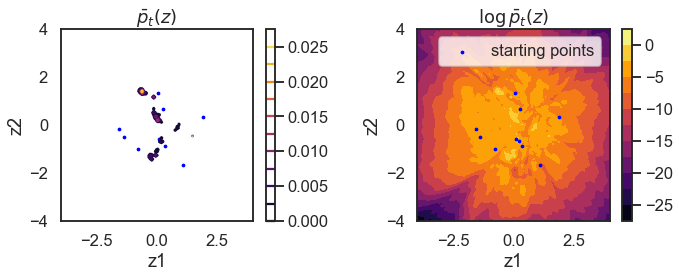

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
cp = plot_dens_proj(axs[0], gan_target, batch_size)
fig.colorbar(cp, ax=axs[0]) # Add a colorbar to a plot
axs[0].scatter(*start_mnist[:, [PROJ_DIM1, PROJ_DIM2]].T.cpu(), color='blue', s=5, alpha=1.0, label='starting points')

cp = plot_log_dens_proj(axs[1], gan_target, batch_size)
fig.colorbar(cp, ax=axs[1]) # Add a colorbar to a plot
axs[1].scatter(*start_mnist[:, [PROJ_DIM1, PROJ_DIM2]].T.cpu(), color='blue', s=5, alpha=1.0, label='starting points')

fig.tight_layout()
plt.legend()
plt.show()

In [16]:
proposal_scale = 1.0
n_particles = 3
proposal = MNormal(torch.zeros(gan_target.dim).to(device), torch.eye(gan_target.dim).to(device) * proposal_scale**2)

isir_chains, acceptance_rates = ISIR(start_mnist, gan_target, proposal, N_SAMPLES, BURN_IN, n_particles=n_particles, verbose=True)

100%|██████████| 1100/1100 [00:01<00:00, 599.52it/s]


Text(0.5, 0, 'Iteration')

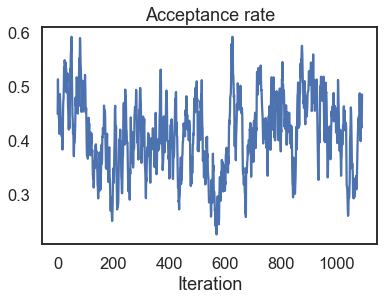

In [17]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

In [18]:
step_size = 0.01
mala_chains, acceptance_rates = MALA(start_mnist, gan_target, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 1100/1100 [00:03<00:00, 304.09it/s]


Text(0.5, 0, 'Iteration')

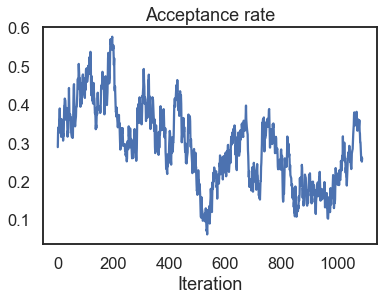

In [19]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

In [20]:
step_size = 0.01
proposal_scale = 1.0
n_particles = 3
n_mala_steps = 1
proposal = MNormal(
    torch.zeros(gan_target.dim).to(device), torch.eye(gan_target.dim).to(device) * proposal_scale**2)

ex2_chains, acceptance_rates = Ex2MCMC(start_mnist, gan_target, proposal, N_SAMPLES, BURN_IN, 
    step_size=step_size, n_particles=n_particles, n_mala_steps=n_mala_steps, verbose=True)

100%|██████████| 1100/1100 [00:09<00:00, 112.62it/s]


Text(0.5, 0, 'Iteration')

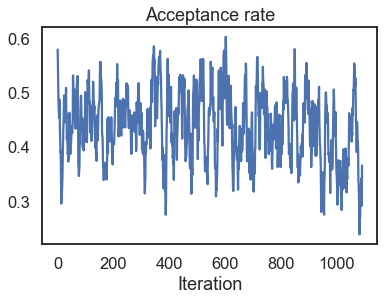

In [21]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

In [22]:
step_size = 0.01
num_leapfrog_steps = 10

hmc_chains = HMC(start_mnist.to(device), gan_target, N_SAMPLES, BURN_IN, step_size=step_size, num_leapfrog_steps=num_leapfrog_steps, verbose=True)

Sample: 100%|██████████| 1100/1100 [00:28, 38.06it/s, step size=1.54e-02, acc. prob=0.865]


In [23]:
# step_size = 0.005
# # num_leapfrog_steps = 10

# nuts_chains = NUTS(start_mnist.to(device), gan_target, N_SAMPLES, 20, step_size=step_size, verbose=True)

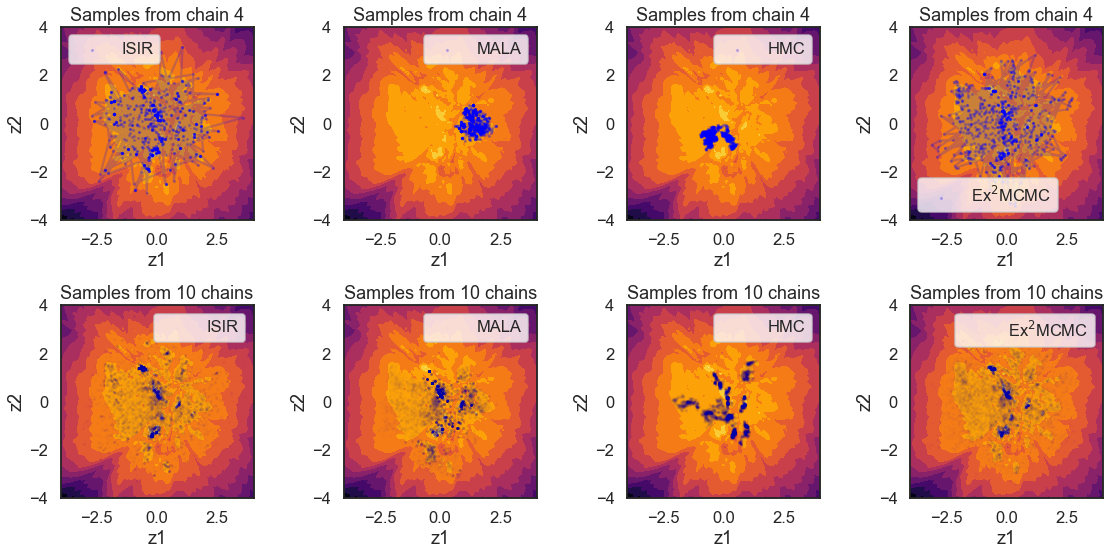

In [24]:
chain_id = 4

N_pts = 100

a = 2.0
xlim = ylim = (-2*a, 2*a)
xlist = np.linspace(*xlim, N_pts)
ylist = np.linspace(*ylim, N_pts)
X, Y = np.meshgrid(xlist, ylist)
grid = np.vstack([X.ravel(), Y.ravel()])
points = np.zeros((X.shape[0],X.shape[1], 2),dtype=float)
points[..., PROJ_DIM1] = X
points[..., PROJ_DIM2] = Y
points = points.reshape(-1, 2)

log_dens_vals = torch.cat([gan_target.log_prob(batch.to(device)).detach().cpu() \
    for batch in torch.FloatTensor(points).split(batch_size)], 0)
log_dens_vals = log_dens_vals.reshape(N_pts, N_pts).numpy()

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for idx, (chains, name) in enumerate(zip([isir_chains, mala_chains, hmc_chains, ex2_chains], ['ISIR', 'MALA', 'HMC', r'Ex$^2$MCMC'])):
    result = chains[..., chain_id, [PROJ_DIM1, PROJ_DIM2]]
    axs[0, idx].contourf(X, Y, log_dens_vals, levels=10, cmap='inferno')
    axs[0, idx].plot(*result.T, color='blue', alpha=0.2)
    axs[0, idx].scatter(*result.T, color='blue', s=3, alpha=0.2, label=name)

    axs[0, idx].set_xlabel(fr'z{PROJ_DIM1 + 1}')
    axs[0, idx].set_ylabel(fr'z{PROJ_DIM2 + 1}')
    axs[0, idx].set_aspect('equal')
    axs[0, idx].set_title(f'Samples from chain {chain_id}')
    axs[0, idx].legend()


    result = chains[..., [PROJ_DIM1, PROJ_DIM2]].reshape(-1, 2)
    axs[1, idx].contourf(X, Y, log_dens_vals, levels=10, cmap='inferno')
    axs[1, idx].scatter(*result.T, color='blue', s=3, alpha=0.01, label=name)

    axs[1, idx].set_xlabel(fr'z{PROJ_DIM1 + 1}')
    axs[1, idx].set_ylabel(fr'z{PROJ_DIM2 + 1}')
    axs[1, idx].set_aspect('equal')
    axs[1, idx].set_title(f'Samples from {N_CHAINS} chains')
    axs[1, idx].legend()
    
    # result = chains[..., [PROJ_DIM1, PROJ_DIM2]].reshape(-1, 2)
    # kernel = gaussian_kde(np.unique(result, axis=0).T, bw_method=0.15)
    # grid = np.vstack([X.ravel(), Y.ravel()])
    # kde = np.reshape(kernel(grid).T, X.shape)
    # cp = axs[1, idx].contour(X, Y, kde, levels=10, cmap='inferno')
    # axs[1, idx].set_title(f'KDE, samples from {name}')
    # axs[1, idx].set_aspect('equal')

fig.tight_layout()

plt.show()

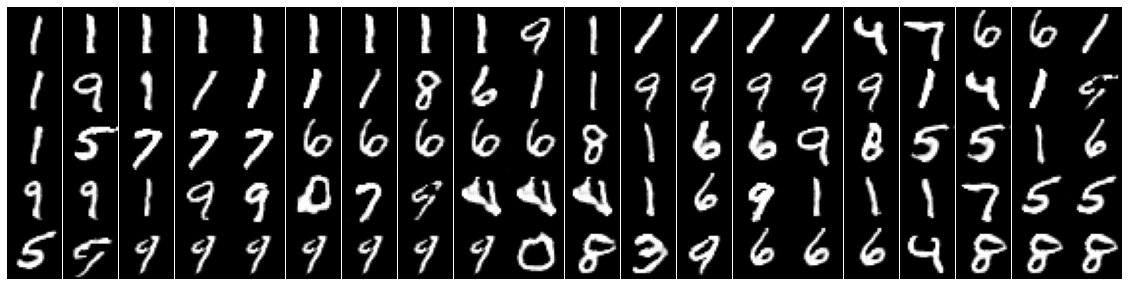

In [25]:
show_every_n = 2
show_first_n = 100
sampled_mnist = gen_mnist(isir_chains[0 : show_first_n * show_every_n : show_every_n, chain_id, :].to(device))

fig = plt.figure(figsize=(20,5))
axs = [fig.add_subplot(5, 20, i+1) for i in range(100)]

for idx, ax in enumerate(axs):
    ax.imshow(sampled_mnist[idx, 0].detach().cpu().numpy(), cmap='gray')
    ax.axis('off')
fig.subplots_adjust(wspace=0, hspace=0)

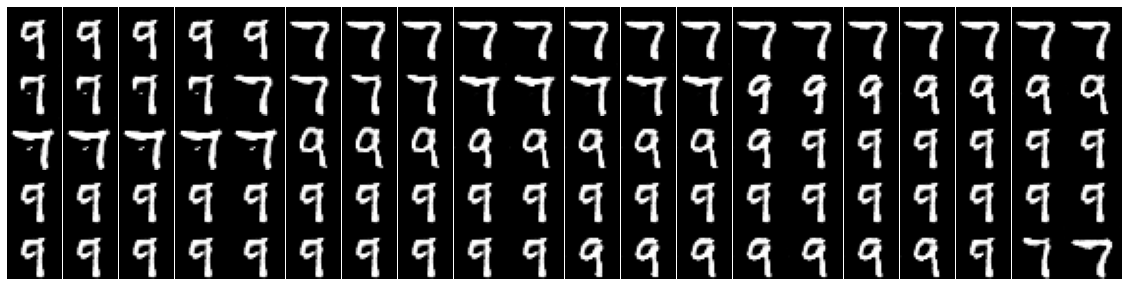

In [26]:
show_every_n = 2
show_first_n = 100
sampled_mnist = gen_mnist(mala_chains[0 : show_first_n * show_every_n : show_every_n, chain_id, :].to(device))

fig = plt.figure(figsize=(20,5))
axs = [fig.add_subplot(5, 20, i+1) for i in range(100)]

for idx, ax in enumerate(axs):
    ax.imshow(sampled_mnist[idx, 0].detach().cpu().numpy(), cmap='gray')
    ax.axis('off')
fig.subplots_adjust(wspace=0, hspace=0)

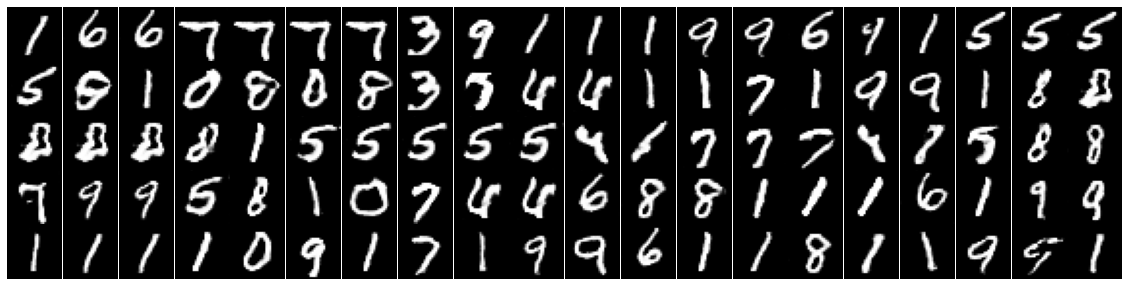

In [27]:
show_every_n = 2
show_first_n = 100
sampled_mnist = gen_mnist(ex2_chains[0 : show_first_n * show_every_n : show_every_n, chain_id, :].to(device))

fig = plt.figure(figsize=(20,5))
axs = [fig.add_subplot(5, 20, i+1) for i in range(100)]

for idx, ax in enumerate(axs):
    ax.imshow(sampled_mnist[idx, 0].detach().cpu().numpy(), cmap='gray')
    ax.axis('off')
fig.subplots_adjust(wspace=0, hspace=0)

In [28]:
class DiscriminatorMNISTWGAN(DiscriminatorMNIST):
    def __init__(self):
        super().__init__()
        self.adv_layer = nn.Sequential(nn.Linear(512, 1, bias=False))

    def forward(self, img, foo=None):
        for p in self.parameters():
           p.data.clamp_(-0.06, 0.06)
        
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [29]:
! if [ ! -f "mnist_wgan_2d.ckpt" ]; then gdown --id 1MaZj4vXqDw1EdOoWX3ckOYFn7_5r-Ocr; fi

In [30]:
dis_mnist = DiscriminatorMNISTWGAN()
dis_mnist.to(device);

# batch_size = 128
# latent_dim_mnist = 2
# prior_mnist = MNormal(
#     torch.zeros(latent_dim_mnist).to(device), torch.eye(latent_dim_mnist).to(device)
#     )
# gen_mnist.prior = prior_mnist

# start_mnist = prior_mnist.sample((N_CHAINS,))

In [31]:
gen_mnist.load_state_dict(torch.load('mnist_wgan_2d.ckpt')[0])
dis_mnist.load_state_dict(torch.load('mnist_wgan_2d.ckpt')[1])
gen_mnist.eval()
dis_mnist.eval();

gan_target = TargetGAN(gen_mnist, dis_mnist, device=device, batch_size=batch_size)

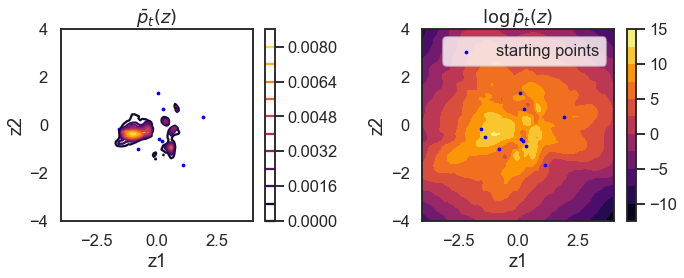

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
cp = plot_dens_proj(axs[0], gan_target, batch_size)
fig.colorbar(cp, ax=axs[0]) # Add a colorbar to a plot
axs[0].scatter(*start_mnist[:, [PROJ_DIM1, PROJ_DIM2]].T.cpu(), color='blue', s=5, alpha=1.0, label='starting points')

cp = plot_log_dens_proj(axs[1], gan_target, batch_size)
fig.colorbar(cp, ax=axs[1]) # Add a colorbar to a plot
axs[1].scatter(*start_mnist[:, [PROJ_DIM1, PROJ_DIM2]].T.cpu(), color='blue', s=5, alpha=1.0, label='starting points')

fig.tight_layout()
plt.legend()
plt.show()

In [33]:
proposal_scale = 1.0
n_particles = 3
proposal = MNormal(torch.zeros(gan_target.dim).to(device), torch.eye(gan_target.dim).to(device) * proposal_scale**2)

isir_chains, acceptance_rates = ISIR(start_mnist, gan_target, proposal, N_SAMPLES, BURN_IN, n_particles=n_particles, verbose=True)

100%|██████████| 1100/1100 [00:01<00:00, 567.70it/s]


Text(0.5, 0, 'Iteration')

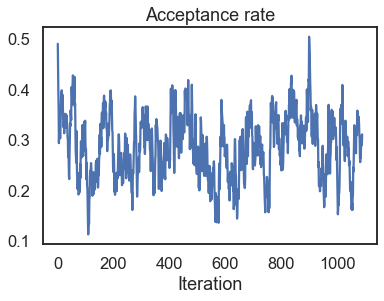

In [34]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

In [35]:
step_size = 0.01
mala_chains, acceptance_rates = MALA(start_mnist, gan_target, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

100%|██████████| 1100/1100 [00:03<00:00, 299.17it/s]


Text(0.5, 0, 'Iteration')

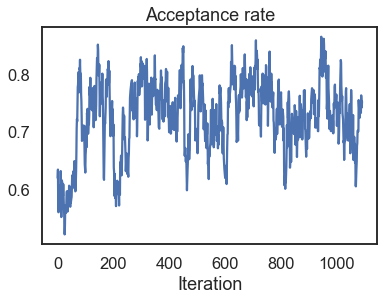

In [36]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

In [37]:
step_size = 0.01
proposal_scale = 1.0
n_particles = 3
n_mala_steps = 1
proposal = MNormal(
    torch.zeros(gan_target.dim).to(device), torch.eye(gan_target.dim).to(device) * proposal_scale**2)

ex2_chains, acceptance_rates = Ex2MCMC(start_mnist, gan_target, proposal, N_SAMPLES, BURN_IN, 
    step_size=step_size, n_particles=n_particles, n_mala_steps=n_mala_steps, verbose=True)

100%|██████████| 1100/1100 [00:10<00:00, 107.60it/s]


Text(0.5, 0, 'Iteration')

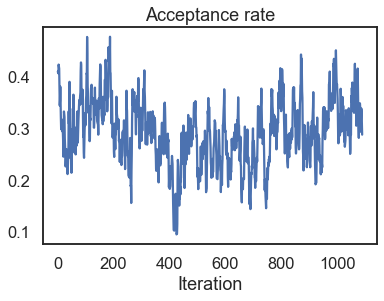

In [38]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

In [39]:
step_size = 0.01
num_leapfrog_steps = 10

hmc_chains = HMC(start_mnist.to(device), gan_target, N_SAMPLES, BURN_IN, step_size=step_size, num_leapfrog_steps=num_leapfrog_steps, verbose=True)

Sample: 100%|██████████| 1100/1100 [00:04, 267.35it/s, step size=3.99e-01, acc. prob=0.665]


In [40]:
# step_size = 0.005
# # num_leapfrog_steps = 10

# nuts_chains = NUTS(start_mnist.to(device), gan_target, N_SAMPLES, 20, step_size=step_size, verbose=True)

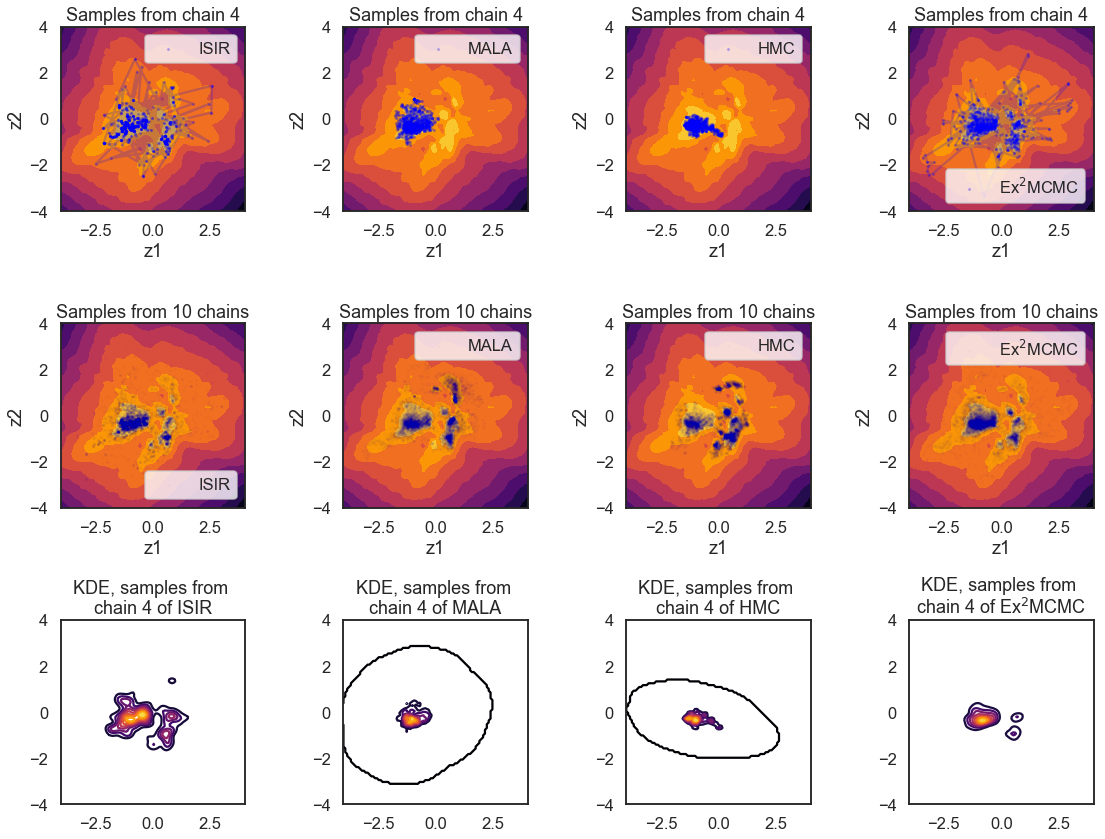

In [41]:
chain_id = 4

N_pts = 100

a = 2.0
xlim = ylim = (-2*a, 2*a)
xlist = np.linspace(*xlim, N_pts)
ylist = np.linspace(*ylim, N_pts)
X, Y = np.meshgrid(xlist, ylist)
grid = np.vstack([X.ravel(), Y.ravel()])
points = np.zeros((X.shape[0],X.shape[1], 2),dtype=float)
points[..., PROJ_DIM1] = X
points[..., PROJ_DIM2] = Y
points = points.reshape(-1, 2)

log_dens_vals = torch.cat([gan_target.log_prob(batch.to(device)).detach().cpu() \
    for batch in torch.FloatTensor(points).split(batch_size)], 0)
log_dens_vals = log_dens_vals.reshape(N_pts, N_pts).numpy()

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
for idx, (chains, name) in enumerate(zip([isir_chains, mala_chains, hmc_chains, ex2_chains], ['ISIR', 'MALA', 'HMC', r'Ex$^2$MCMC'])):
    result = chains[..., chain_id, [PROJ_DIM1, PROJ_DIM2]]
    axs[0, idx].contourf(X, Y, log_dens_vals, levels=10, cmap='inferno')
    axs[0, idx].plot(*result.T, color='blue', alpha=0.2)
    axs[0, idx].scatter(*result.T, color='blue', s=3, alpha=0.2, label=name)

    axs[0, idx].set_xlabel(fr'z{PROJ_DIM1 + 1}')
    axs[0, idx].set_ylabel(fr'z{PROJ_DIM2 + 1}')
    axs[0, idx].set_aspect('equal')
    axs[0, idx].set_title(f'Samples from chain {chain_id}')
    axs[0, idx].legend()


    result = chains[..., [PROJ_DIM1, PROJ_DIM2]].reshape(-1, 2)
    axs[1, idx].contourf(X, Y, log_dens_vals, levels=10, cmap='inferno')
    axs[1, idx].scatter(*result.T, color='blue', s=3, alpha=0.01, label=name)

    axs[1, idx].set_xlabel(fr'z{PROJ_DIM1 + 1}')
    axs[1, idx].set_ylabel(fr'z{PROJ_DIM2 + 1}')
    axs[1, idx].set_aspect('equal')
    axs[1, idx].set_title(f'Samples from {N_CHAINS} chains')
    axs[1, idx].legend()
    
    result = chains[..., chain_id, [PROJ_DIM1, PROJ_DIM2]]
    kernel = gaussian_kde(np.unique(result, axis=0).T, bw_method=0.17) # magic const
    grid = np.vstack([X.ravel(), Y.ravel()])
    kde = np.reshape(kernel(grid).T, X.shape)
    axs[2, idx].contour(X, Y, kde, levels=10, cmap='inferno')
    axs[2, idx].set_title(f'KDE, samples from \nchain {chain_id} of {name}')
    axs[2, idx].set_aspect('equal')

fig.tight_layout()

plt.show()

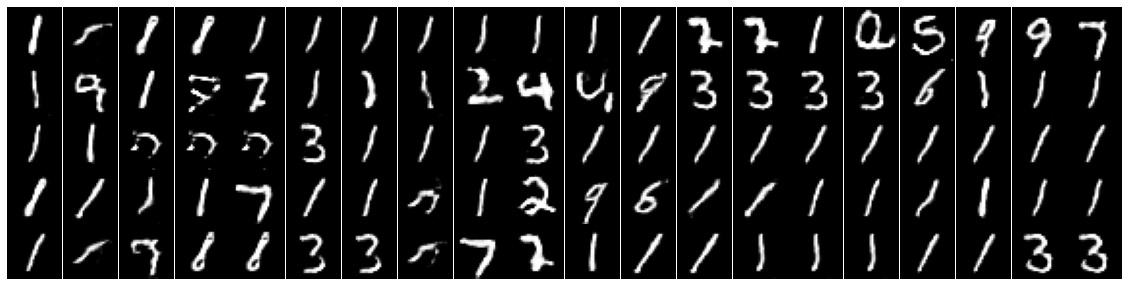

In [42]:
show_every_n = 5
show_first_n = 100
sampled_mnist = gen_mnist(isir_chains[0 : show_first_n * show_every_n : show_every_n, chain_id, :].to(device))

fig = plt.figure(figsize=(20,5))
axs = [fig.add_subplot(5, 20, i+1) for i in range(100)]

for idx, ax in enumerate(axs):
    ax.imshow(sampled_mnist[idx, 0].detach().cpu().numpy(), cmap='gray')
    ax.axis('off')
fig.subplots_adjust(wspace=0, hspace=0)

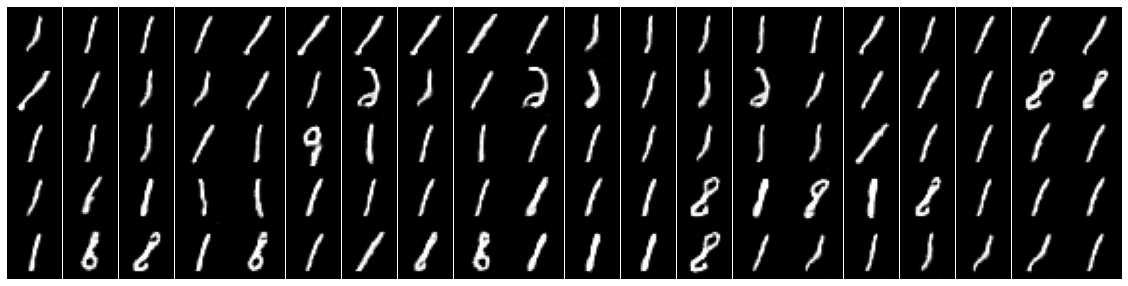

In [43]:
show_every_n = 5
show_first_n = 100
sampled_mnist = gen_mnist(mala_chains[0 : show_first_n * show_every_n : show_every_n, chain_id, :].to(device))

fig = plt.figure(figsize=(20,5))
axs = [fig.add_subplot(5, 20, i+1) for i in range(100)]

for idx, ax in enumerate(axs):
    ax.imshow(sampled_mnist[idx, 0].detach().cpu().numpy(), cmap='gray')
    ax.axis('off')
fig.subplots_adjust(wspace=0, hspace=0)

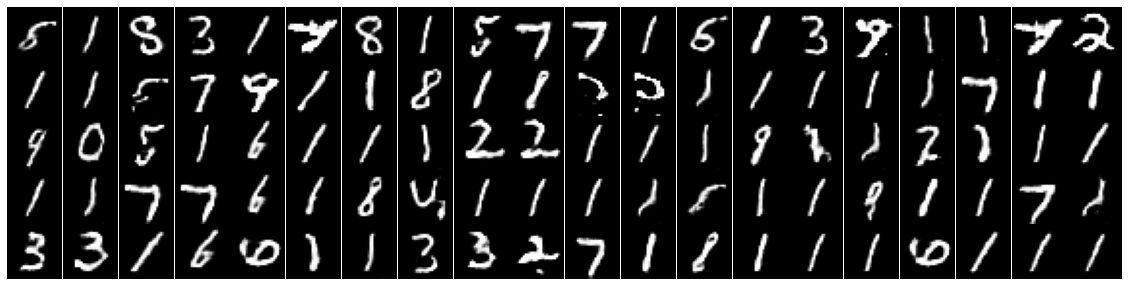

In [44]:
show_every_n = 5
show_first_n = 500
sampled_mnist = gen_mnist(ex2_chains[0 : show_first_n * show_every_n : show_every_n, chain_id, :].to(device))

fig = plt.figure(figsize=(20,5))
axs = [fig.add_subplot(5, 20, i+1) for i in range(100)]

for idx, ax in enumerate(axs):
    ax.imshow(sampled_mnist[idx, 0].detach().cpu().numpy(), cmap='gray')
    ax.axis('off')
fig.subplots_adjust(wspace=0, hspace=0)